# Mass measurements of Globular Clusters

The goal of the project is to use images of a globular cluster (GC), take the radial intensity distribution and do a simple geometric deprojection to estimate the mass of the stars in the cluster as a function of distance to the center. The students needs to be explained the CCD data reduction steps (giving a first example of how you load/divide two images) and let them make that part in a python notebook. Then the second part is to think how they can deproject and also implement that in the notebook.

This notebook shows examples of images taken with a small telescope on the campus and the MAIA imager of the Mercator telescope. The data can be found at: https://owncloud.ster.kuleuven.be/index.php/s/M77ApigK4CFGg23 and includes bias', flat-fields, and images of the GC M53 and M12. The course is a lot about significance, errors, etc.   So it is important you let them think about errors and error propagation, error bars etc.

## Libraries & Constants

In [1]:
# Libraries
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import astropy.io.fits as fits
import scipy.optimize as opt
import scipy.stats as stats
%matplotlib notebook

# Error propagation
import uncertainties.unumpy as up
import uncertainties.umath  as um
from uncertainties import ufloat
def val(x): return up.nominal_values(x)
def err(x): return up.std_devs(x)

# Absolute magnitudes of the Sun in different bandpasses
# See: http://mips.as.arizona.edu/~cnaw/sun_2006.html
M_sun_bol = 4.74            # [mag]
M_sun_r   = 4.65            # [mag]
M_sun_g   = 5.14            # [mag]
M_sun_u   = 6.45            # [mag]
# Other constants
G          = 6.67408e-11    # [m3 kg-1 s-2]
M_sun      = 1.989e30       # [kg]
# Unit conversions
pc2meter   = 3.08567758e16  # [m]
pc2ly      = 0.3066013938   # [ly]
arcsec2rad = 4.84813681e-6  # [rad]

## Functions

In [2]:
def linear(inputArray, scale_min=None, scale_max=None):
    """
    Performs linear scaling of the input numpy array.
    
    @param inputArray [array]: Image data array
    @param scale_min  [float]: Minimum data value
    @param scale_max  [float]: Maximum data value
    
    @return: image data array
    """
    imageData = np.array(inputArray, copy=True)

    if scale_min == None:
        scale_min = imageData.mean()-2*imageData.std() #imageData.min()
    if scale_max == None:
        scale_max = imageData.mean()+2*imageData.std() #imageData.max()

    imageData = imageData.clip(min=scale_min, max=scale_max)
    imageData = (imageData - scale_min) / (scale_max - scale_min)
    indices = np.where(imageData < 0)
    imageData[indices] = 0.0
    indices = np.where(imageData > 1)
    imageData[indices] = 1.0

    return imageData

# Combine array for color plot
def rgb(image_r, image_g, image_b):
    """
    This function takes 3 arrays representing each a RGB color
    and combine them into a 3D array (a single image array).
    """
    # Copy data not to overwrite origials
    img_r = np.copy(image_r)
    img_g = np.copy(image_g)
    img_b = np.copy(image_b)
    # Make 3D array
    h = image_r.shape[0]
    w = image_r.shape[1]
    img = np.zeros((h, w, 3), dtype=float)
    img[:,:,0] = linear(img_r)
    img[:,:,1] = linear(img_g)
    img[:,:,2] = linear(img_b)
    return img


def convolution(signalIn, convType, carBox):
    """
    This utility makes the proper convolution to a signal dataset.
    Notice: the carbox size here is twice what is default by numpy.

    @param convType [string] : Filter is either: median or mean
    @param signalIn [array]  : Signal needed for processing
    @param carBox   [int]    : Integer used as car-box size for convolution

    @return signalOut [array]: Convolved signal
    """

    # Constants
    n     = carBox
    S     = signalIn.copy()   # Avoid overwritting the input signal
    S_new = np.zeros(len(S))
    nzero = np.zeros(2*n+1)   # Optimization constant

    # Select convolution
    if convType == 'log':     conv = np.log10
    if convType == 'mean':    conv = np.mean
    if convType == 'median':  conv = np.median

    # Interval: d[n, 1+n, ... , N-1, N-n]
    for i in range(len(S)-2*n):
        S_new[n+i] = conv(S[range((n+i)-n, (n+i)+n+1)])

    for i in range(n):
        # Interval: d[-n, -(n-1), ... , n-1, n] - Low end of data
        low = nzero
        low[range(n-i)] = S[0]*np.ones(n-i)
        low[-(n+1+i):]  = S[range(0, n+1+i)]
        S_new[i]        = conv(low)

        # Interval: d[N-n, N-(n-1), ... , N+(n-1), N+n] - High end of data
        high = nzero
        high[range(n+1+i)] = S[range(len(S)-(n+i+1), len(S))]
        high[-(n-i):]      = S[-1]*np.ones(n-i)
        S_new[len(S)-1-i]  = conv(high)

    # Output
    signalOut = S_new
    return signalOut


# Crop image around object (also to lower computation)
def crop(array, borders):
    """
    Given an array and 4 values smaller than the array dimension, this
    function will cut out the original array to a smaller array.
    
    @param array   [array] : Input array
    @param borders [list]  : List of [x1, x2, y1, y2]
    """
    return array[borders[2]:borders[3], borders[0]:borders[1]]


# Define geometric function to for distance measure
def distance(x,y):
    return np.sqrt((y-ycen)**2 + (x-xcen)**2)

## Cluster Properties

In [3]:
def cluster(name):
    """
    Function to store cluster properties. Genrally some important papers provide properties of GCs:
    
    https://www.physics.mcmaster.ca/~harris/mwgc.dat
    https://doi.org/10.1111/j.1365-2966.2005.09080.x (Cluster mass)
    2019MNRAS.489.3093S (Gaia parallaxes)
    
    In the following the angular radial measures from literature are measured in the V bandpass.
    We assume that the cluster's are spherical symmetric.
    
    vc : Central velocity dispersion   [m/s]
    rc : Core radius                   [arcsec]
    rh : Half-light angular radius     [arcsec]
    sc : Core surface brigthness in V  [mag/arcsec**2]
    lc : Core luminosity density       [log10(Lsun/pc**3)]
    pc : Parallax of cluster           [arcsec]
    mc : Cluster mass                  [M_sun]
    """
    
    if name == 'M5': # NGC 5904
        vc = ufloat(5.5, 0.4) * 1e3 
        rc = ufloat(0.44, 0.) * 60
        rh = ufloat(1.77, 0.) * 60
        sc = ufloat(16.09, 0.)
        lc = ufloat(3.88, 0.)
        pc = ufloat(0.1139, 0.0018) * 1e-3
        mc = ufloat(8.57, 0.) * 1e5 
    
    if name == 'M12': # NGC 6218
        vc = ufloat(4.5, 0.4) * 1e3 
        rc = ufloat(0.79, 0.) * 60
        rh = ufloat(1.77, 0.) * 60
        sc = ufloat(18.10, 0.)
        lc = ufloat(3.23, 0.)
        pc = ufloat(0.1584, 0.0022) * 1e-3
        mc = ufloat(8.7, 0.) * 1e4    
        
    if name == 'M53': # NGC 5024
        vc = ufloat(4.4, 0.9) * 1e3 
        rc = ufloat(0.35, 0.) * 60
        rh = ufloat(1.31, 0.) * 60
        sc = ufloat(17.38, 0.)
        lc = ufloat(3.07, 0.)
        pc = ufloat(0.0157, 0.0028) * 1e-3
        mc = ufloat(8.26, 0.) * 1e5 
        
    return vc, rc, rh, sc, lc, pc, mc

# ONLY RUN ONE TELESCOPE- AND CLUSTER CODE-BLOCK!

## KUL Student Telescope data

In [4]:
# Activate this block for student telescope post-processing
telStudent  = True
telMercator = False

# Instrumental specifications: SBIG ST-8 Dual CCD Camera
pixel_size   = 9.0e-3    # [mm]
focal_length = 600.0     # [mm]
platescale   = 1/arcsec2rad * pixel_size/focal_length  # [arcsec/pixel]
gain         = 1

# Path and data
dataDir = os.getcwd() + '/data_studentTelescope_2019/'

BF = fits.open(dataDir + "bias_0.01.fits")[0].data

DF_100s   = fits.open(dataDir + "Dark_100.fits")[0].data # taken offline
DF_150s   = fits.open(dataDir + "Dark_150.fits")[0].data # taken offline
DF_300s   = fits.open(dataDir + "Dark_300.fits")[0].data  # taken offline
DF_300s_n = fits.open(dataDir + "dark_frame_300.fits")[0].data # taken during observing night

FF_C = fits.open(dataDir+"Flat_filter1.fits")[0].data # taken offline 0.01sec integration (Clear filter)
FF_U = fits.open(dataDir+"Flat_ufilter.fits")[0].data # taken offline 0.01sec integration
FF_B = fits.open(dataDir+"flat_bfilter.fits")[0].data # taken offline 0.01sec integration
FF_V = fits.open(dataDir+"flat_vfilter.fits")[0].data # taken offline 0.01sec integration
FF_R = fits.open(dataDir+"Flat_rfilter.fits")[0].data # taken offline 0.01sec integration

### M5

<IPython.core.display.Javascript object>


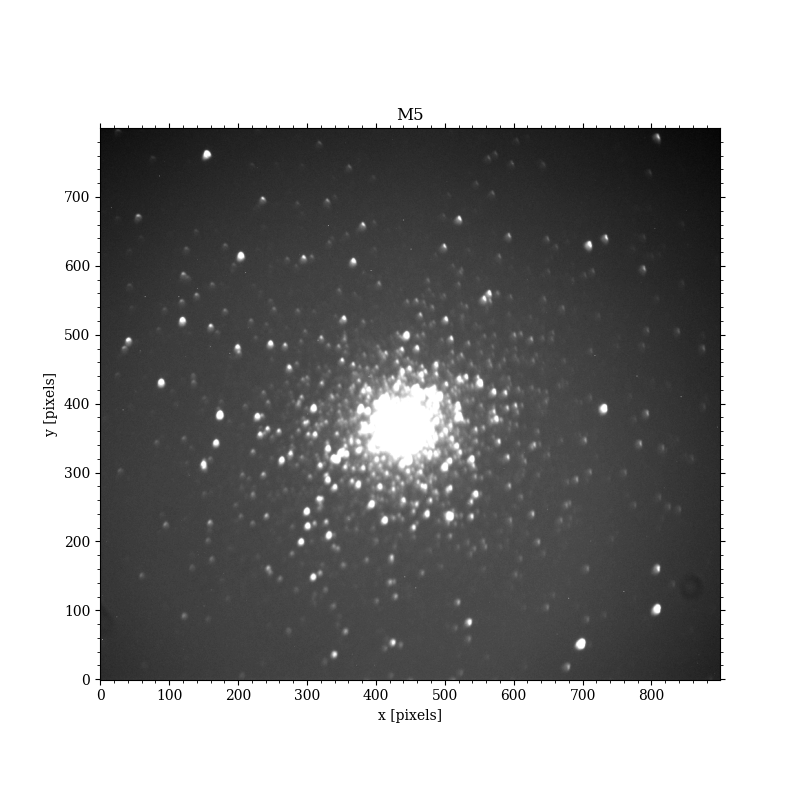

In [5]:
# Cluster information
vc, rc, rh, sc, lc, pc, mc = cluster('M5')

# Load image files
SF = fits.open(dataDir + "M5_open_100.fits")[0].data  # Clear (c) filter 100s integration

# Select borders for this specific cluster
borders = [300, 1200, 0, 800]

# Select images for post-processing
BF = crop(BF, borders)
DF = crop(DF_100s, borders)
FF = crop(FF_C, borders)
SF = crop(SF, borders)
M_sun_x = M_sun_bol

# Plot cluster
plt.figure(figsize=(8,8))
plt.imshow(linear(SF), cmap='gray', origin='lower')
plt.title('M5')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.show()

## MAIA RGB data

In [18]:
# Activate this block for MAIA post-processing
telStudent  = False
telMercator = True

# Instrumental specifications: SBIG ST-8 Dual CCD Camera (Eddington CCD)
platescale    = 0.275         # [arcsec/pixel] 
gain          = 1.250         # [e-/ADU]

# Path to data
dataDir = os.getcwd() + '/data_maia_2015/'

# CALIBRATION FRAMES 
# [Bias see: *736_TECH*]
# [Flat see: *861-870_FFS*]

# Load Red filter 
BF_r = fits.open(dataDir + "00636736_TECH_r.fits")[0].data
FF_r = fits.open(dataDir + "00636870_FFS_r.fits")[0].data
# Load Green filter
BF_g = fits.open(dataDir + "00636736_TECH_g.fits")[0].data
FF_g = fits.open(dataDir + "00636870_FFS_g.fits")[0].data
# Load Blue filter
BF_u = fits.open(dataDir + "00636736_TECH_u.fits")[0].data
FF_u = fits.open(dataDir + "00636870_FFS_u.fits")[0].data

### M53

<IPython.core.display.Javascript object>


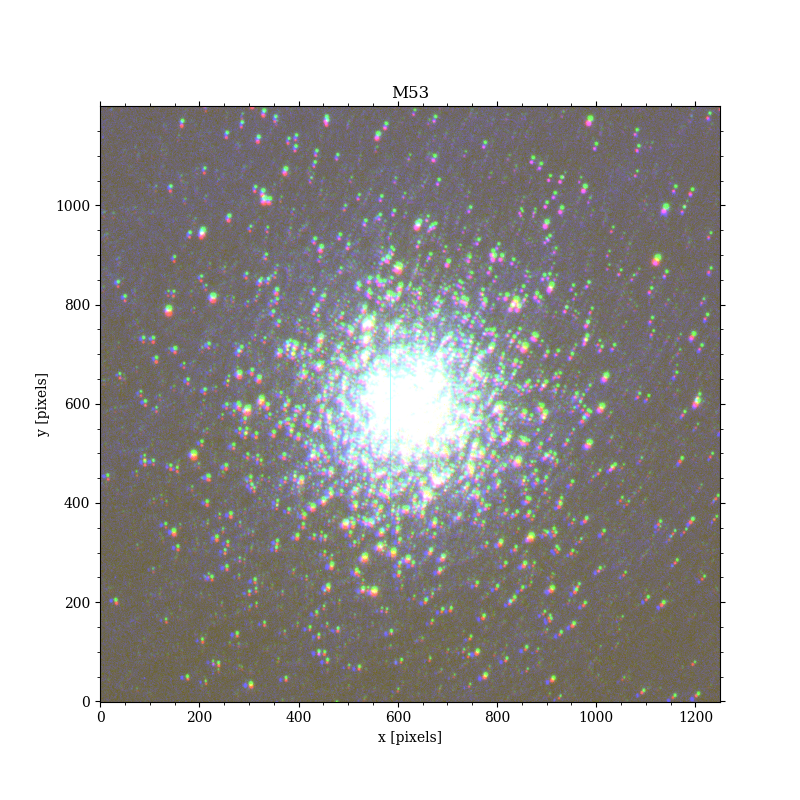

In [17]:
# Cluster information
vc, rc, rh, sc, lc, pc, mc = cluster('M53')

# Open fits files
hdul_r = fits.open(dataDir + "00636915_OBJ_r.fits")[0]
hdul_g = fits.open(dataDir + "00636915_OBJ_g.fits")[0]
hdul_u = fits.open(dataDir + "00636915_OBJ_u.fits")[0]

# Object frames [see: *910-915_OBJ*]
SF_r = hdul_r.data
SF_g = hdul_g.data
SF_u = hdul_u.data

# An image RGB has the same exposure time
texp = float(hdul_r.header['EXPTIME'])

# Select borders for this specific cluster
borders = [250, 1500, 1000, 2200]

BF_r = crop(BF_r, borders)
FF_r = crop(FF_r, borders)
SF_r = crop(SF_r, borders)

BF_g = crop(BF_g, borders)
FF_g = crop(FF_g, borders)
SF_g = crop(SF_g, borders)

BF_u = crop(BF_u, borders)
FF_u = crop(FF_u, borders)
SF_u = crop(SF_u, borders)

# Plot cluster
plt.figure(figsize=(8,8))
plt.imshow(linear(rgb(SF_r, SF_g, SF_u)), origin='lower')
plt.title('M53')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.show()

# Select filter for post-processing
BF = BF_u
FF = FF_u
SF = SF_u
M_sun_x = M_sun_u

### M12

<IPython.core.display.Javascript object>


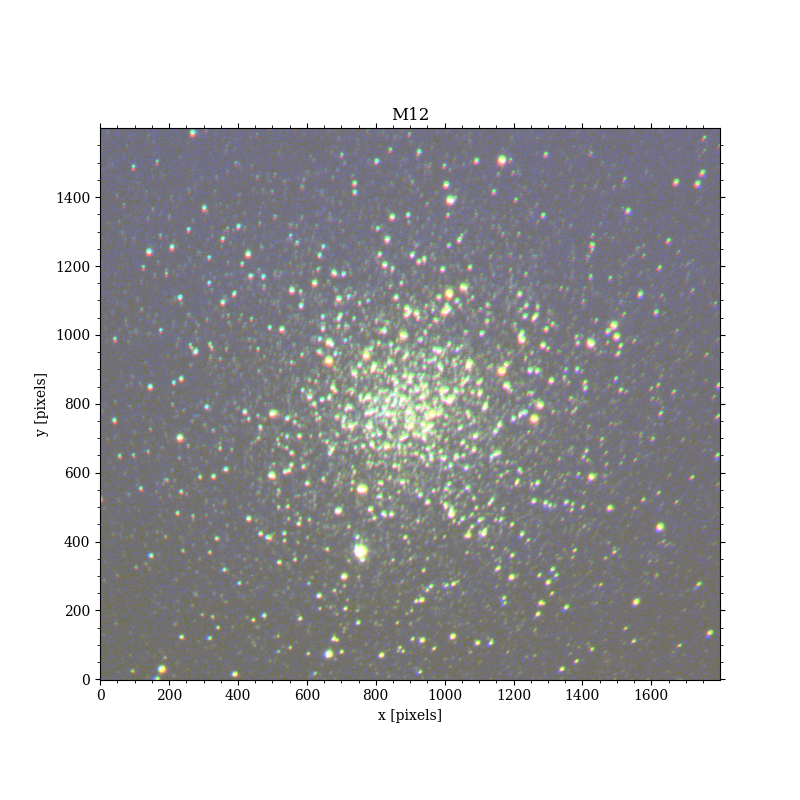

In [19]:
vc, rc, rh, sc, lc, pc, mc = cluster('M12')

# Object frames [see: *921-925_OBJ*]
# Notice u-filter is very special for this target hence use *924_OBJ*
SF_r = fits.open(dataDir + "00636924_OBJ_r.fits")[0].data 
SF_g = fits.open(dataDir + "00636924_OBJ_g.fits")[0].data
SF_u = fits.open(dataDir + "00636924_OBJ_u.fits")[0].data

# Select borders for this specific cluster
borders = [100, 1900, 900, 2500]

BF_r = crop(BF_r, borders)
FF_r = crop(FF_r, borders)
SF_r = crop(SF_r, borders)

BF_g = crop(BF_g, borders)
FF_g = crop(FF_g, borders)
SF_g = crop(SF_g, borders)

BF_u = crop(BF_u, borders)
FF_u = crop(FF_u, borders)
SF_u = crop(SF_u, borders)

# Plot cluster
plt.figure(figsize=(8,8))
plt.imshow(linear(rgb(SF_r, SF_g, SF_u)), origin='lower')
plt.title('M12')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.show()

# Select filter for post-processing
BF = BF_r
FF = FF_r
SF = SF_r
M_sun_x = M_sun_r

## Image reduction

The image reduction depends on wheather bias', darks, and flats all or present. For MAIA the CCD are cooled sufficiently (but if possible check this!) to not include darks, however, for the student telescope (or any other non-professionel telescope) darks should always be included for the best reduction result. Notice that if the for low statistic dark and flat frames (meaning using only a one or a few frames of each) will introduce more noise than actually acomplishing a good correction if low quality frames are present. Notice also that for low exposure times (typically lower than 300s) you will probably not see a big difference while using bias subtracted darks or not.  

Usually the removal of comics are also done as part of this step, but this is far beyond this project (although simple IRAF, pyraf, etc. algorithms are available within the astronomy community). Notice that in the following for the student telescope, we assume that the dark represent a statically good bias (which is not always the case), hence choose your calibrations frames carefully.

<IPython.core.display.Javascript object>


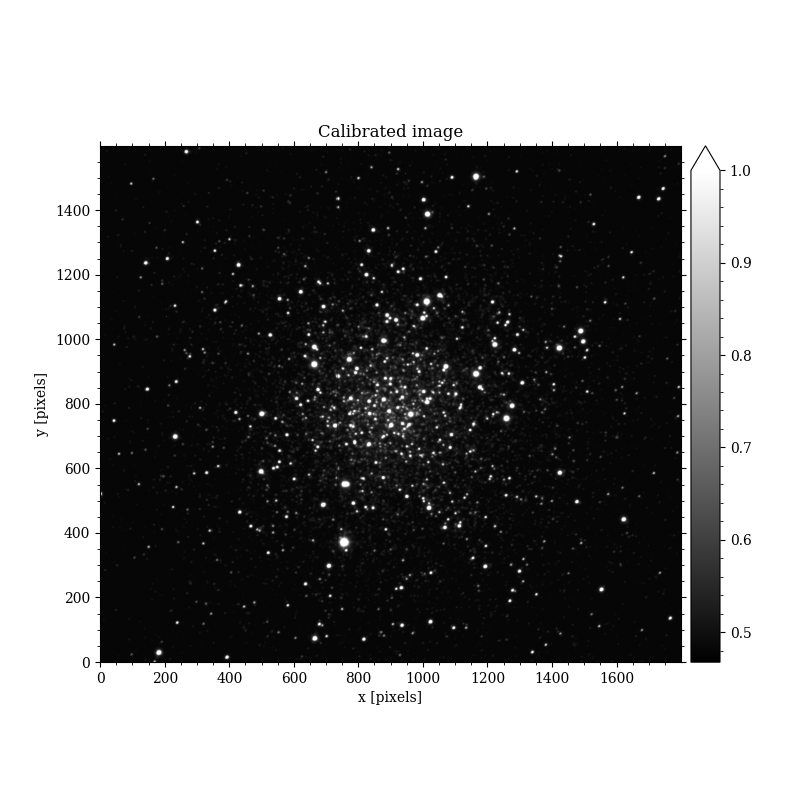

In [20]:
# Subtract bias level (and defects in CCD)
FF_bias = FF - BF
SF_bias = SF - BF

# If defects are still present avoid encountering dividing with zero
FF_bias[FF_bias <= 0] = np.median(FF_bias)
SF_bias[SF_bias <= 0] = np.median(SF_bias)

# Normalize flat-field to preserve real counts
FF_norm = FF_bias / np.max(FF_bias)

# IMAGE REDUCTION FOR STUDENT TELESCOPE

if telStudent is True:
    DF_bias = DF - BF
    DF_bias[DF_bias <= 0] = np.median(DF_bias)
    # Calibrated Science Frame
    CSF = (SF_bias - DF_bias) / FF_norm

# IMAGE REDUCTION FOR MERCATOR/MAIA

if telMercator is True:
    # Calibrated Science Frame
    CSF = SF_bias / FF_norm
    
# Check calibration images!
fig, ax = plt.subplots(figsize=(8,8))
img = plt.imshow(linear(CSF), cmap='gray', origin='lower')
div = make_axes_locatable(ax)
cax = div.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(img, ax=ax, cax=cax, extend='max')
ax.set_title('Calibrated image')
ax.set_xlabel('x [pixels]')
ax.set_ylabel('y [pixels]')
plt.show()

## Stellar cluster centroid

The center of the cluster should by the students first be determined by eye (reading off the (x, y) coordinates). If time permits they can proceed finding the stellar cluster center by
1. Peak of (x,y) intensity profile
2. From a smoothed (x,y) intensity profile
3. Non-linear fitting to the (x,y) intesity profiles

We show these three methods in the following. Notice that without a cosmics removed before this step, the normalizing occasionally not represent the overall data but that of a sigle cosmic contaminant. In such a case the non-linear fitting procedure will must likely fail.

In [21]:
# BY NOW YOU SHOULD HAVE INITIALIZED 1 TELESCOPE AND 1 CLUSTER DATASET
# THEN CHOOSE FILTER TO WORK WITH ONWARDS!

science = CSF

# PREPARE SLICES TO WORK WITH

# First collapse both axes respectively
xsum = np.sum(science, axis=0)
ysum = np.sum(science, axis=1)

# Normalizing
xslice = xsum / ( np.max(xsum) - np.min(xsum) )
yslice = ysum / ( np.max(ysum) - np.min(ysum) )

# Scale to zero-point for optimal fitting
xslice = xslice - np.min(xslice)
yslice = yslice - np.min(yslice)

# Ranges used for modelling and plotting
xrange = np.arange(len(xslice))
yrange = np.arange(len(yslice))

# FIND CENTER BY MAXIMUM OF SLICES

xmax = np.argmax(xslice)
ymax = np.argmax(yslice)

# FIND CENTER BY SIMPLE CONVOLUTION DATA SMOOTHING

smooth  = 20
xsmooth = convolution(xslice, 'median', smooth)
ysmooth = convolution(yslice, 'median', smooth)

xpos = np.argmax(xsmooth)
ypos = np.argmax(ysmooth)

# FIND CENTER BY NON-LINEAR LEAST-SQUARE FITTING

# lorentzian(x, x0, a, gam) = a * gam**2 / ( gam**2 + ( x - x0 )**2)
from lmfit.models import LorentzianModel
model = LorentzianModel()

# Find x fit
xpars = model.guess(xslice, x=xrange)
xout  = model.fit(xslice, xpars, x=xrange)
xfit  = int(xout.params['center'].value)

# Find y fit
ypars = model.guess(yslice, x=yrange)
yout  = model.fit(yslice, ypars, x=yrange)
yfit  = int(yout.params['center'].value)

<IPython.core.display.Javascript object>


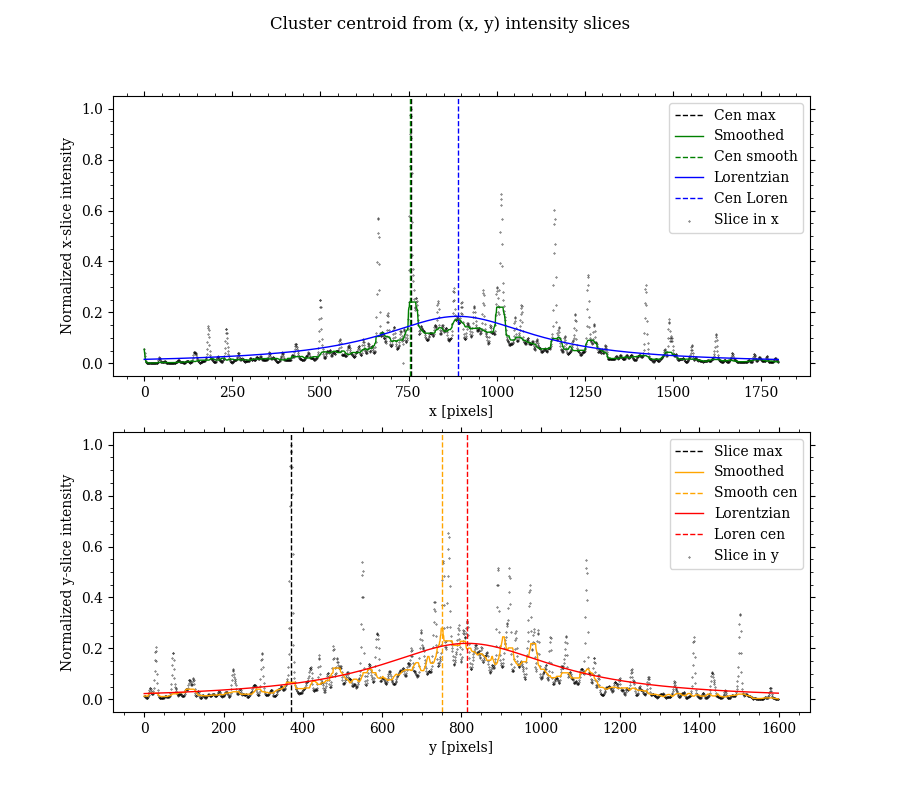

In [22]:
# Plot the results from all 3 methods
fig, ax = plt.subplots(2, 1, figsize=(9, 8))
plt.suptitle('Cluster centroid from (x, y) intensity slices')

ax[0].scatter(xrange, xslice, color='k', s=0.1, label='Slice in x')
ax[0].axvline(xmax, color='k', linestyle='--', lw=1, label='Cen max')
ax[0].plot(xrange, xsmooth, 'g-', lw=1, label='Smoothed')
ax[0].axvline(xpos, color='g', linestyle='--', lw=1, label='Cen smooth')
ax[0].plot(xrange, xout.best_fit, 'b-', lw=1, label='Lorentzian')
ax[0].axvline(xfit, color='b', linestyle='--', lw=1, label='Cen Loren')

ax[0].set_xlabel('x [pixels]')
ax[0].set_ylabel('Normalized x-slice intensity')
ax[0].legend()

#-------------------------

ax[1].scatter(yrange, yslice, color='k', s=0.1, label='Slice in y')
ax[1].axvline(ymax, color='k', linestyle='--', lw=1, label='Slice max')
ax[1].plot(yrange, ysmooth, color='orange', linestyle='-', lw=1, label='Smoothed')
ax[1].axvline(ypos, color='orange', linestyle='--', lw=1, label='Smooth cen')
ax[1].plot(yrange, yout.best_fit, 'r-', lw=1, label='Lorentzian')
ax[1].axvline(yfit, color='r', linestyle='--', lw=1, label='Loren cen')

ax[1].set_xlabel('y [pixels]')
ax[1].set_ylabel('Normalized y-slice intensity')
ax[1].legend()

plt.show()

## Deprojection intensity distributions

In [309]:
# Define which centroids to use
xcen = xfit
ycen = yfit

# Find 2D projected pixel intensities
dist = 300
intensities = [] #intensiteit
distances   = [] #afstand

for x in range(xcen-dist, xcen+dist): 
    for y in range(ycen-dist, ycen+dist): 
        distances.append(distance(x, y))
        intensities.append(science[y, x])
        
# Rebinning the distance/intensity into shells
nShells        = 100
rebIntensities = []
errIntensities = []
rebFluxes      = []
errFluxes      = []

for i in range(nShells):
    w = []
    for k in range(0, len(distances)):
        if i-0.5 <= distances[k] < i+0.5:
            w.append(intensities[k]) 
    # Intensity
    rebIntensities.append(np.mean(w))
    errIntensities.append(np.std(w))
    # Fluxes
    rebFluxes.append(np.sum(w))
    errFluxes.append(np.std(w))

# Rescale rebinned measure onto cartesian pixel distance grid
rebDistances = np.arange(nShells)  * np.max(distances)/nShells

<IPython.core.display.Javascript object>


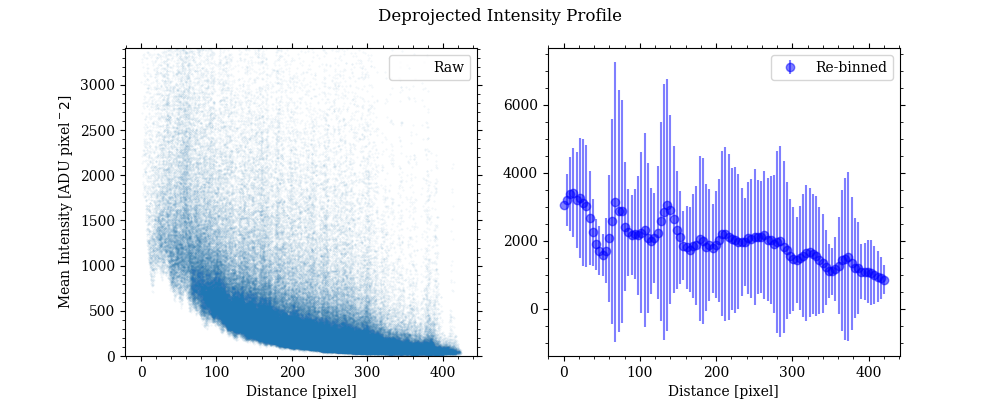

In [310]:
# Plot intensity profiles (be patient!)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle('Deprojected Intensity Profile')

# Raw intensity profile
ax[0].scatter(distances, intensities, s=0.1, alpha=0.1, label='Raw')
ax[0].set_xlabel("Distance [pixel]")
ax[0].set_ylabel('Mean Intensity [ADU pixel$^-2$]')
ax[0].set_ylim(0, np.max(rebIntensities))
ax[0].legend()

# Rebinned intensity profile 
ax[1].errorbar(rebDistances, rebIntensities, errIntensities, fmt='o', color='b', alpha=0.5, label='Re-binned')
ax[1].set_xlabel('Distance [pixel]')
ax[1].legend()

plt.show()

## Physical dimensions from Gaia parallax


Parallax = (1.57+/-0.28)e-11 mas
Distance = 64+/-11 kpc

Core radius (Rc: red)    : 6.5+/-1.2 pc
H-L  radius (Rh: orange) : 24+/-4 pc
User radius (Rm: yellow) : 33+/-4 pc


<IPython.core.display.Javascript object>


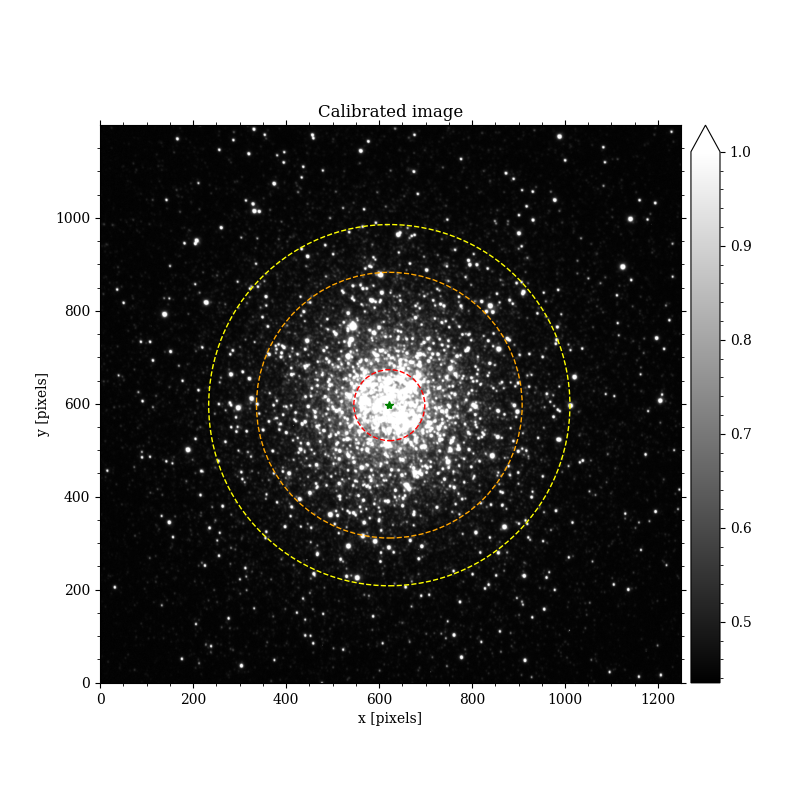

In [311]:
# We start converting the units
r = rebDistances * platescale  # [arcsec] Array of radii
r = r[1:]                      # Remove first element that is zero

# Distance and raddi of cluster
d  = 1/pc                             # [pc]
r  = val(d) * np.tan(r * arcsec2rad)  # [pc]
Rc = d * um.tan(rc * arcsec2rad)      # [pc] Core radius
Rh = d * um.tan(rh * arcsec2rad)      # [pc] Half-light radius

# Conversion of pixel size in pc
pc2pixel = val(rh) / (val(Rh) * platescale)

# User defined radius for mass determination
# We use uncertainty from half-light radius
#-------------------------------------------
R  = ufloat(33.0, err(Rh))      # [pc]
ru = um.atan(R/d) / arcsec2rad  # [arcsec]
#-------------------------------------------

print('')
print('Parallax = {} mas'.format(pc/1e6))
print('Distance = {} kpc'.format(d/1e3))
print('')
print('Core radius (Rc: red)    : {0} pc'.format(Rc))
print('H-L  radius (Rh: orange) : {0} pc'.format(Rh))
print('User radius (Rm: yellow) : {0} pc'.format(R))

# Plot radii ontop of fits image
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Calibrated image')
# Plots image
img = plt.imshow(linear(CSF), cmap='gray', origin='lower')
# Plot circles
ax.plot(xcen, ycen, 'g*')
cc = plt.Circle((xcen, ycen), val(Rc)*pc2pixel,   color='red',    fill=False, linestyle='--')
ch = plt.Circle((xcen, ycen), val(Rh)*pc2pixel,   color='orange', fill=False, linestyle='--')
cm = plt.Circle((xcen, ycen), val(R)*pc2pixel,    color='yellow', fill=False, linestyle='--')
ax.add_artist(cc)
ax.add_artist(ch)
ax.add_artist(cm)
# Plot colorbar
div = make_axes_locatable(ax)
cax = div.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(img, ax=ax, cax=cax, extend='max')
# Labels
ax.set_xlabel('x [pixels]')
ax.set_ylabel('y [pixels]')
plt.show()

## Cluster Mass determination

### Comparison to gravitational potential

<IPython.core.display.Javascript object>


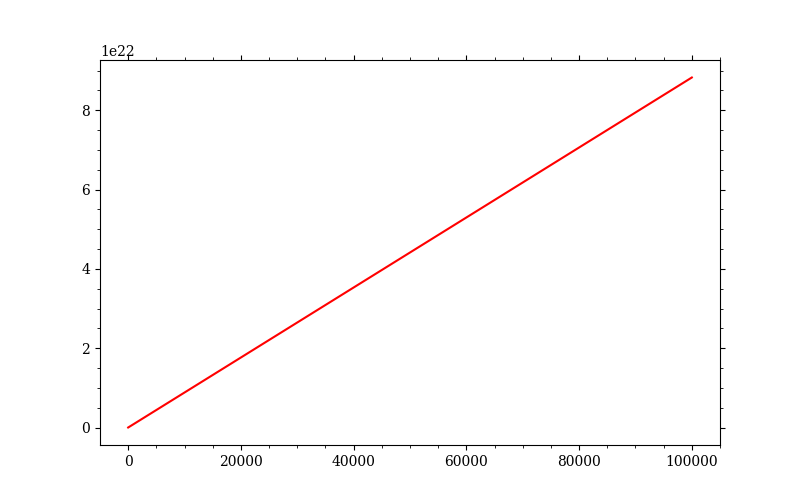

In [312]:
# Function to calculate the potential with constants a and b
U = 1 + -2*G*val(mc)*.9891*1e30/(30*3.08567758*1e16)
def mass(x):
    return - x*U / (2*G)

#print(-2*G*val(mc)*.9891*1e30/(30*3.08567758*1e16))

x = np.linspace(0, 1e5, 100)

plt.figure(figsize=(8, 5))
plt.plot(x, mass(x), 'r-')
plt.show()

### Cluster Mass from Viral Theorem

To verify our results we can compare the above mass estimate that to a gravitational potential. In order to use the virial theorem, we need to make some assumptions. Following the exercise given [here](http://spiff.rit.edu/classes/phys440/lectures/glob_clus/glob_clus.html) it is possible find the viral mass by

$$M = \frac{3}{2}\frac{R \, \sigma_r^2}{G}$$

It is important that the students remember the that they use following assumptions (which most likely will induce systematic errors into our results - that's for the discussion)

- **The system is in equilibrium:** In order for the simple relationship between kinetic and gravitational potential energy to hold, the system must be, on average, in a stable state. Individual bodies may be falling inwards, or flying outwards, or circling around the center of mass; but a roughly equal number must be moving inwards and outwards. If a majority of the stars were to move outwards together, in sync, or if the cluster were gravitationally unbound, then we could not apply the virial theorem. 

In addition, if the following conditions are true, the calculations become even simpler.

- **Brightness are represensative for mass:** The (few) bodies which you measure are truly representative of the many) in the system
- **All bodies have the same mass:** This is clearly wrong (and also a contradiction to the previous assumption, but elsewise an Initial Mass Function (IMF) needs to be calculated/assumed. 
- **The system is not rotating:** If it were rotating, one would have to include terms for centrifugal energy. 

In [313]:
# Calculate viral mass 
Mv = 3/2. * R*pc2meter * vc**2 / G / M_sun

### Mass-Intensity relation (Advanced)

This exercise have never been done by a student before, so this will probably never be realistic, however, for fun let's see how we determine the cluster in an absolute way. To simplify some expression, like the distance modulus we denote the apparent and absolute surface brightness as $s$ and $S$, respectively. To to find $S$ we first need to convert our intensities ($i$) (in units of ADU per square pixel) to units of magnitude per square parsec. Hence first to go from pixels to arcsec we use the known CCD platescale ($\delta x$)

$$ 
I = \delta x^{-2} i
\quad\Rightarrow\quad
\left[\frac{\text{ADU}}{\text{arcsec}^2}\right] = \left[\frac{\text{pixel}^2}{\text{arcsec}^2}\right] \left[\frac{\text{ADU}}{\text{pixel}^2}\right]
$$



Now we need to convert intensities to fluxes using the knowledge of the CCD gain ($g$) and exposure time ($t_{\text{exp}}$)

$$
F = g \frac{I}{t_{\text{exp}}}  
\quad\Rightarrow\quad
\left[\frac{e^{-}}{\text{arcsec}^2 s}\right] = \left[\frac{e^{-}}{\text{ADU}}\right] \left[\frac{\text{ADU}}{\text{arcsec}^2}\right] \left[\frac{1}{\text{s}}\right]
$$

With the flux we can convert to apparent surface brightness using the distance modulus 

$$ s = -2.5\log(F) + 25
\quad\Rightarrow\quad
\left[\frac{\text{mag}}{\text{arcsec}^2}\right] = \log \left[\frac{\text{flux}}{\text{arcsec}^2}\right]
$$

We then convert to absolute magnitude using the knowledge of the parallax ($p$) and thus distance ($d$)

$$ 
S = s - 5\log(d) + 5 \quad\text{with}\quad d[\text{pc}] = \frac{1}{p[\text{arcsec}]} 
$$  

Assuming that the cluster's brightness is represensative for its mass, we will in the following use the relation of the surface brightness going from units of magnitude per square arcsec to units of solar luminosity ($L_{\odot}$) per square parsec

$$ S \left[\frac{\text{mag}}{\text{arcsec}^2}\right] = M_{\odot_X} + 21.572 − 2.5 \log S \left[\frac{L_{\odot}}{\text{pc}^2}\right] \quad\Rightarrow\quad S \left[\frac{L_{\odot}}{\text{pc}^2}\right] = 10^{\left(\frac{M_{\odot_X} + 21.572 - S \left[\frac{\text{mag}}{\text{arcsec}^2}\right]}{2.5}\right)}$$

where $M_{\odot_X}$ are the absolute magnitude of the Sun in the chosen color-band $X$. Since have measured the surface brightness in increasing shells we need to infer the mass by integrating the surface brightness over these shells to find the mass as function of cluster raii

$$
M(R_c) \sim L(R_c) \sim 2 \pi \int_0^{R_c} S(r) \, R(r) dr
$$


In [314]:
# Annulus of intensities and fluxes 
i = up.uarray(rebIntensities, errIntensities) / platescale**2  # [mean ADU/pixel**2]
f = up.uarray(rebFluxes, errFluxes) / platescale**2            # [ADU/arcsec**2]
# Avoid dividing by first zero entry
i = i[1:]
f = f[1:]

# Find flux [e-/arcsec**2/s]
F = gain * i / texp

# Convert to surface brightness [mag/arcsec**2] (m - M = 5 log(d/10pc))
# We are here using Vega (in V bandpass approximation) flux of 25:
s = -2.5 * up.log10(F) + 25

# Bring to absolute magnitude scale
S_mag = s - 5 * um.log10(d) + 5

# Covert surface brightness to [L_sun/pc**2]
S = up.log10((M_sun_x + 21.562 - S_mag) / 2.5)

# Indices for different radii
dexc = (np.abs(r - Rc)).argmin()
dexh = (np.abs(r - Rh)).argmin()
dexm = (np.abs(r - R )).argmin()

# We assume light-to-mass are identical distributions
Mc = 2*np.pi * np.sum(S[:dexc] * r[:dexc]**1)
Mh = 2*np.pi * np.sum(S[:dexh] * r[:dexh]**1)
M  = 2*np.pi * np.sum(S[:dexm] * r[:dexm]**1)

print(Mc)
print(Mh)
print(M)

358.0+/-2.7
5162+/-33
(9.74+/-0.06)e+03


<IPython.core.display.Javascript object>


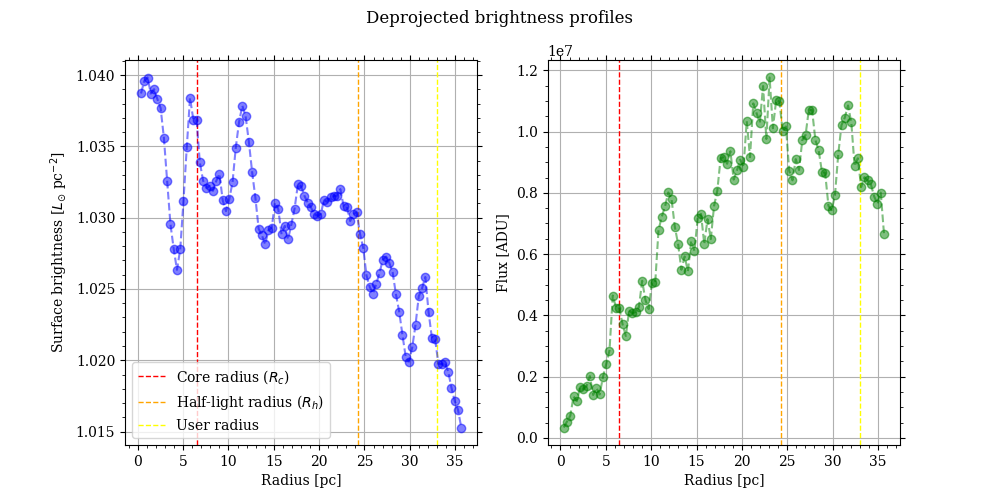

In [315]:
# Plot results (log x-scale, y inverted)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle('Deprojected brightness profiles')

# Intensities
ax[0].errorbar(r, val(S), err(S)*0, fmt='o--', color='b', alpha=0.5)
ax[0].axvline(val(Rc),   color='red',    linestyle='--', lw=1, label='Core radius ($R_c$)')
ax[0].axvline(val(Rh),   color='orange', linestyle='--', lw=1, label='Half-light radius ($R_h$)')
ax[0].axvline(val(R),    color='yellow', linestyle='--', lw=1, label='User radius')
ax[0].set_xlabel('Radius [pc]')
ax[0].set_ylabel('Surface brightness [$L_{\odot}$ pc$^{-2}$]')
ax[0].tick_params(axis='both', which='major')
#ax[0].set_xscale('log')
ax[0].grid('yes')
ax[0].legend()

# Fluxes
ax[1].errorbar(r, val(f), err(f)*0, fmt='o--', color='g', alpha=0.5, label='Fluxes')
ax[1].axvline(val(Rc),   color='red',    linestyle='--', lw=1)
ax[1].axvline(val(Rh),   color='orange', linestyle='--', lw=1)
ax[1].axvline(val(R),    color='yellow', linestyle='--', lw=1)
ax[1].set_xlabel('Radius [pc]')
ax[1].set_ylabel('Flux [ADU]')
ax[1].tick_params(axis='both', which='major')
ax[1].grid('yes')

plt.show()

## Comparing Results

In [316]:
# Notice that the confined radius and mass are the result presented here!
print('')
print('Parallax = {} mas'.format(pc/1e6))
print('Distance = {} kpc'.format(d/1e3))
print('')
print('Radius core (angular) = {:.3f} pc ({:.3f} arcsec)'.format(Rc, rc))
print('Radius H-L  (angular) = {:.3f} pc ({:.3f} arcsec)'.format(Rh, rh))
print('Radius user (angular) = {:.3f} pc ({:.3f} arcsec)'.format(R, ru))
print('')
print('Mass light-core = {:.3e} M_sun'.format(Mc))
print('Mass light-half = {:.3e} M_sun'.format(Mh))
print('Mass light cal. = {:.3e} M_sun'.format(M))
print('Mass viral cal. = {:.3e} M_sun'.format(Mv))
print('Mass literature = {:.3e} M_sun'.format(mc))


Parallax = (1.57+/-0.28)e-11 mas
Distance = 64+/-11 kpc

Radius core (angular) = 6.485+/-1.157 pc (21.000+/-0 arcsec)
Radius H-L  (angular) = 24.272+/-4.329 pc (78.600+/-0 arcsec)
Radius user (angular) = 33.000+/-4.329 pc (106.866+/-23.659 arcsec)

Mass light-core = (3.580+/-0.027)e+02 M_sun
Mass light-half = (5.162+/-0.033)e+03 M_sun
Mass light cal. = (9.743+/-0.064)e+03 M_sun
Mass viral cal. = (2.228+/-0.957)e+05 M_sun
Mass literature = (8.260+/-0)e+05 M_sun
